# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.under_sampling import RandomUnderSampler


In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Download Dataset

In [3]:
column_names_file = "../Dataset/kddcup.names"
columns = []
first = True
with open(column_names_file, 'r') as f:
    for line in f:
        if first:
            first = False
            continue
        line = line.strip()
        columns.append(line.split()[0][:-1])

print(columns)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [21]:
file_path = "../Dataset/kddcup.data.corrected"
df = pd.read_csv(file_path, names=columns)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,tcp,http,SF,215,45076,0,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,162,4528,0,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,236,1228,0,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,233,2032,0,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


# Pre-processing

In [5]:
# Remove trailing periods from the last column values
df.rename(columns={df.columns[-1]: 'label'}, inplace=True)
df['label'] = df['label'].str.rstrip('.')  # clean trailing period if any

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,label
0,tcp,http,SF,215,45076,0,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal
0,tcp,http,SF,162,4528,0,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal
0,tcp,http,SF,236,1228,0,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal
0,tcp,http,SF,233,2032,0,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal
0,tcp,http,SF,239,486,0,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal


In [6]:
df.label.value_counts()

label
smurf              2807886
neptune            1072017
normal              972781
satan                15892
ipsweep              12481
portsweep            10413
nmap                  2316
back                  2203
warezclient           1020
teardrop               979
pod                    264
guess_passwd            53
buffer_overflow         30
land                    21
warezmaster             20
imap                    12
rootkit                 10
loadmodule               9
ftp_write                8
multihop                 7
phf                      4
perl                     3
spy                      2
Name: count, dtype: int64

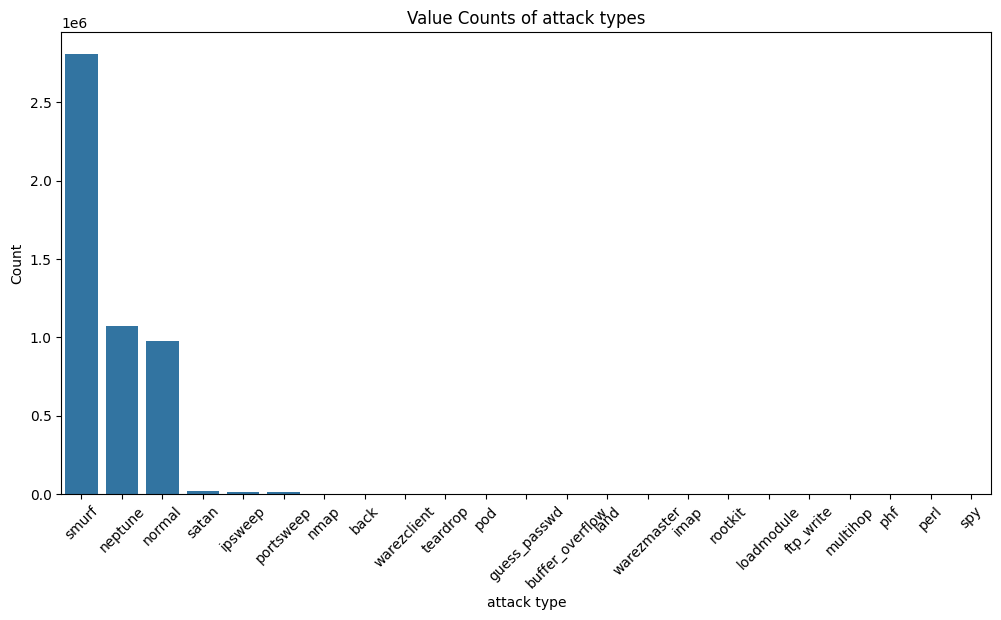

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Value Counts of attack types')
plt.xlabel('attack type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()  

In [8]:
# 1 for probing attacks, 0 for others
probing_attacks = ['ipsweep', 'nmap', 'portsweep', 'satan']
df['attack_type'] = df.label.apply(lambda x: 1 if x in probing_attacks else 0)

In [9]:
df.attack_type.value_counts()

attack_type
0    4857329
1      41102
Name: count, dtype: int64

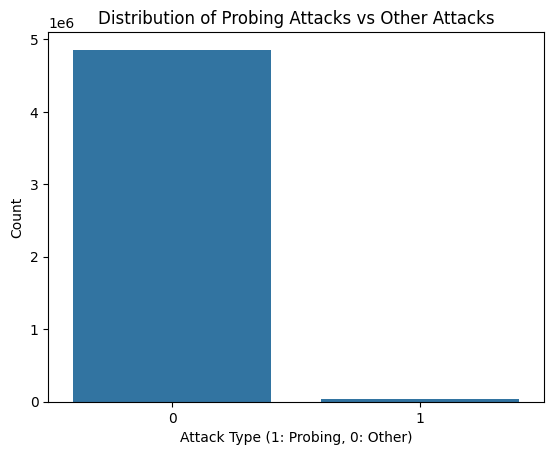

In [10]:
sns.countplot(x='attack_type', data=df)
plt.title('Distribution of Probing Attacks vs Other Attacks')
plt.xlabel('Attack Type (1: Probing, 0: Other)')
plt.ylabel('Count')
plt.show()

Highly Imbalanced Dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4898431 entries, 0 to 0
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     object 
 1   protocol_type                object 
 2   service                      object 
 3   flag                         int64  
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  num_outboun

In [12]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

No null values in any column

## Model-Training

In [13]:
X = df.drop(columns=['label', 'attack_type'])
y = df['attack_type']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [14]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = rus.fit_resample(X_train_raw, y_train)

In [15]:
categoric = X_train_bal.select_dtypes(include='object').columns.tolist()
numeric = X_train_bal.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoric)
    ]
)

In [ ]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2', solver='saga', max_iter=500, random_state=RANDOM_STATE
    ))
])

clf.fit(X_train_bal, y_train_bal)
print("Train (balanced set) Acc:", clf.score(X_train_bal, y_train_bal))
print("Test (original dist) Acc:", clf.score(X_test_raw, y_test))

/Users/anshharjai/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train (balanced set) Acc: 0.9862082598382094
Test (original dist) Acc: 0.9846338677557219


The logistic regression model achieved:
	•	Training accuracy: ~98.6%
	•	Test accuracy: ~98.5%

The close performance on training and test sets suggests the model is not overfitting. Despite the strong class imbalance, the undersampling strategy allowed the model to learn probe patterns effectively.

              precision    recall  f1-score   support

           0     0.9999    0.9846    0.9922    971467
           1     0.3518    0.9869    0.5187      8220

    accuracy                         0.9846    979687
   macro avg     0.6758    0.9857    0.7554    979687
weighted avg     0.9944    0.9846    0.9882    979687

[[956521  14946]
 [   108   8112]]
Average Precision (PR AUC): 0.7472704242803909


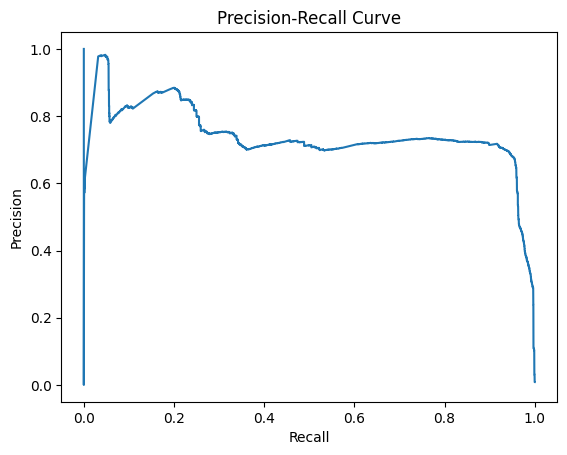

In [17]:
y_prob = clf.predict_proba(X_test_raw)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

ap = average_precision_score(y_test, y_prob)
print("Average Precision (PR AUC):", ap)

prec, rec, thr = precision_recall_curve(y_test, y_prob)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

The classification report shows:
	•	Class 0 (non-probe): Very high precision (0.9999) and recall (0.9846).
	•	Class 1 (probe): High recall (0.9869), but lower precision (0.3518).

This means the model identifies almost all probe attacks (low false negatives), but it sometimes misclassifies non-probes as probes (false positives).

The PR-AUC of ~0.74 reflects moderate precision–recall tradeoff, which is expected for imbalanced data.

In [ ]:
ohe = clf.named_steps['preprocessor'].named_transformers_['cat']
feature_names = numeric + list(ohe.get_feature_names_out(categoric))

coef = clf.named_steps['classifier'].coef_[0]
top_features = sorted(zip(feature_names, coef), key=lambda x: abs(x[1]), reverse=True)[:10]

print("Top 10 informative features:")
for f, w in top_features:
    print(f"{f}: {w:.4f}")

Top 10 informative features:
same_srv_rate: 2.7394
protocol_type_private: 1.8418
dst_host_same_srv_rate: 1.6242
dst_host_diff_srv_rate: 1.5387
count: -1.4650
dst_host_same_src_port_rate: 1.3938
service_REJ: -1.3805
service_RSTR: 1.3414
protocol_type_eco_i: 1.3045
protocol_type_http: -0.9774


In [19]:
for penalty in ['l1', 'l2']:
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            penalty=penalty, solver='saga', max_iter=500, random_state=RANDOM_STATE
        ))
    ])
    clf.fit(X_train_bal, y_train_bal)
    print(penalty.upper(), "Train:", clf.score(X_train_bal, y_train_bal),
          "Test:", clf.score(X_test_raw, y_test))

/Users/anshharjai/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Train: 0.9862386716136488 Test: 0.9846154945406033


/Users/anshharjai/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L2 Train: 0.9862082598382094 Test: 0.9846338677557219


/Users/anshharjai/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anshharjai/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anshharjai/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anshharjai/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


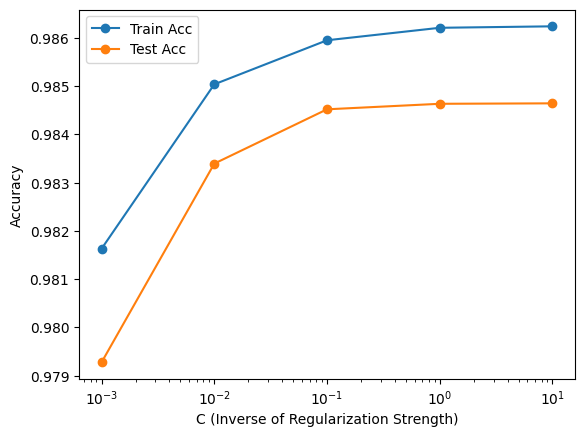

In [20]:
train_accs, test_accs, Cs = [], [], [0.001, 0.01, 0.1, 1, 10]

for c in Cs:
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            penalty='l2', solver='saga', max_iter=500, random_state=RANDOM_STATE, C=c
        ))
    ])
    clf.fit(X_train_bal, y_train_bal)
    train_accs.append(clf.score(X_train_bal, y_train_bal))
    test_accs.append(clf.score(X_test_raw, y_test))

plt.plot(Cs, train_accs, label="Train Acc", marker="o")
plt.plot(Cs, test_accs, label="Test Acc", marker="o")
plt.xscale("log")
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Varying C (inverse of regularization strength) showed:
	•	Low C (strong regularization): Lower accuracy → underfitting.
	•	Higher C: Both train and test accuracy improved, plateauing around C=1 to C=10.

This trend illustrates the bias–variance tradeoff: too much regularization prevents the model from fitting the data well, while moderate to low regularization allows better generalization.

## Summary

The logistic regression model did a solid job spotting probe attacks, reaching around 98.5% accuracy on both training and test data. It sometimes flagged normal traffic as attacks, but it rarely missed an actual probe, which is more important in security. The most useful features matched what we’d expect for network scanning behavior, and regularization didn’t change performance much, showing the model is stable.

Comparing L1 and L2 regularization, I found that both gave similar accuracy, but L1 highlighted fewer key features while L2 spread weights more evenly, showing that the model is stable under different settings.